In [327]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import statsmodels.api as sm
import statsmodels.tools
from scipy import stats

In [328]:
# Read in data, reset index and look at no of rows
df = pd.read_csv('../Data/dataset_for_modelling.csv')
df.reset_index(drop=True, inplace=True)
df.shape[0]

4009

In [329]:
# Look at the head
df.head()

,url,address,property_type,bedrooms,bathrooms,tenure,nearest_station,price,cleaned_address,gcode,outcode_from_gcode,outcode
0,https://www.rightmove.co.uk/properties/1315844...,"Queen Square, Leeds",Detached,5,2,Freehold,0.7,550000,"Queen Square, Leeds","Queen Square, Arena Quarter, Lovell Park, Leed...","Yorkshire,",LS2
1,https://www.rightmove.co.uk/properties/8604795...,"Archery Road, Leeds, West Yorkshire",Terraced,5,1,Freehold,1.0,325000,"Archery Road, Leeds, West Yorkshire","Archery Road, Arena Quarter, Woodhouse, Leeds,...",LS2,LS2
2,https://www.rightmove.co.uk/properties/1326138...,"Hanover Square, Leeds",Terraced,6,3,Freehold,0.8,450000,"Hanover Square, Leeds","Hanover Square, Hyde Park, Leeds, West Yorkshi...",LS3,LS3
3,https://www.rightmove.co.uk/properties/1311469...,"Burley Wood Crescent, Burley, LEEDS",Terraced,3,1,Freehold,0.5,220000,"Burley Wood Crescent, Burley, LEEDS","Burley Wood Crescent, Burley, Leeds, West York...",LS4,LS4
4,https://www.rightmove.co.uk/properties/1322668...,"The Village Street, Burley, Leeds",Detached,5,2,Freehold,0.2,325000,"The Village Street, Burley, Leeds","The Village Street, Burley, Leeds, West Yorksh...",LS4,LS4


# Train/Test splitting

In [330]:
# Create a list of all features
allfeatures = list(df.columns)

In [331]:
allfeatures.remove('price')

In [332]:
# Create X, and y.
X = df[allfeatures]
y = df['price']

In [333]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Feature engineering

In [334]:
def one_hot_encoding(train_df, test_df, categorical_columns):

    # Drop following columns
    train_df = train_df.drop(columns=['url', 'address', 'tenure', 'cleaned_address','gcode','outcode_from_gcode'])
    test_df = test_df.drop(columns=['url', 'address', 'tenure', 'cleaned_address','gcode','outcode_from_gcode'])

    # Append constant
    # Add constant
    train_df = sm.add_constant(train_df)
    # Add constant
    test_df = sm.add_constant(test_df)

    # One Hot encode training dataset
    train_encoded = pd.get_dummies(train_df, drop_first = True, columns=categorical_columns)

    # One Hot encode test dataset
    test_encoded = pd.get_dummies(test_df, columns=categorical_columns)

    # Check if all columns in the test dataset match the training dataset
    missing_columns = set(train_encoded.columns) - set(test_encoded.columns)

    for missing_col in missing_columns:
        test_encoded[missing_col] = 0  # Add missing columns to the test dataset with default value 0

    # Reorder test dataset columns to match the order in the training dataset
    test_encoded = test_encoded[train_encoded.columns]

    return train_encoded, test_encoded

In [335]:
def feature_eng_ohe_proptype_only(df):
    # Drop following columns
    df = df.drop(columns=['url', 'address', 'tenure', 'cleaned_address','gcode','outcode_from_gcode', 'outcode'])
    # One Hot Encode following columns
    df = pd.get_dummies(df, columns = ['property_type'], drop_first = True, prefix = 'Prop_Type')
    # Add constant
    df = sm.add_constant(df)
    return df

# Linear Regression - Model 1

- Use all available features apart from outcode feature
- So used: bedrooms, bathrooms, nearest_station, property_type (One Hot Encoded)

In [336]:
## Feature Engineer
X_train = feature_eng_ohe_proptype_only(X_train)

In [337]:
X_train.head()

,const,bedrooms,bathrooms,nearest_station,Prop_Type_Semi-Detached,Prop_Type_Terraced
2473,1.0,3,2,1.9,1,0
1338,1.0,2,1,0.5,0,1
1613,1.0,4,2,1.4,0,0
1610,1.0,2,1,0.9,0,1
2600,1.0,3,1,1.6,1,0


In [338]:
# Function to fit the lin reg model
def linreg_fitter(y_train, X_train):
    lin_reg = sm.OLS(y_train, X_train)
    lin_regfitted = lin_reg.fit()
    return lin_regfitted

In [339]:
model_1 = linreg_fitter(y_train, X_train)
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     930.4
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:41:52   Log-Likelihood:                -40455.
No. Observations:                3207   AIC:                         8.092e+04
Df Residuals:                    3201   BIC:                         8.096e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1

In [340]:
# Make predictions on X_train
y_preds = model_1.predict(X_train)
rmse = statsmodels.tools.eval_measures.rmse(y_train, y_preds)
print(rmse)

72822.53318328901


In [341]:
# Make predictions on X_test
X_test = feature_eng_ohe_proptype_only(X_test)
y_test_preds = model_1.predict(X_test)
rmse = statsmodels.tools.eval_measures.rmse(y_test, y_test_preds)
print(rmse)

70739.74986852522


# Linear Regression Base model  (Use all features) - Model 2

- Use all available features: bedrooms, bathrooms, nearest_station, property_type (One Hot Encoded) and outcode (One Hot Encoded)

In [342]:
# Read in dataset again, do train-test split then feature engineer to get all the OHE columns
allfeatures = list(df.columns)
allfeatures.remove('price')
# Create X, and y.
X = df[allfeatures]
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [343]:
## Feature engineering
X_train, X_test = one_hot_encoding(X_train, X_test, ['property_type','outcode'])

In [344]:
# Create the second linear regression model
model_2 = linreg_fitter(y_train, X_train)
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     105.9
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:41:52   Log-Likelihood:                -39662.
No. Observations:                3207   AIC:                         7.950e+04
Df Residuals:                    3117   BIC:                         8.005e+04
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [345]:
# Make predictions on train
y_preds = model_2.predict(X_train)
rmse = statsmodels.tools.eval_measures.rmse(y_train, y_preds)
print(rmse)

56862.12425118456


In [346]:
# Make predictions on test
y_test_preds = model_2.predict(X_test)
rmse = statsmodels.tools.eval_measures.rmse(y_test, y_test_preds)
print(rmse)

57962.3894506873


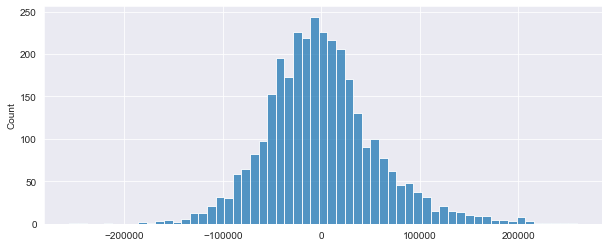

In [347]:
# a histogram of the residuals between y_train and y_pred
residuals = y_train - y_preds
fig = plt.figure(figsize=(10, 4))
sns.histplot(residuals)
plt.show()

# we can see that the residuals are normally distributed, fulfilling one of our assumptions for linear modelling
# However not every variable has a linear relationship with price, nearest_station deffo does not have a linear relationship with price
# So this model fails satisfying all the the assumptions of linear regression

# Linear Regression - Model 3 (all features but nearest_station dropped)

- Make use of all columns including OHE property_type and OHE outcode but drop the nearest_station column

In [348]:
# Get all the OHE columns from model 2 and drop the nearest station column
feature_cols = list(X_train.columns)
feature_cols.remove('nearest_station')

In [349]:
# Create the third linear regression model
model_3 = linreg_fitter(y_train, X_train[feature_cols])
print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     104.7
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:41:53   Log-Likelihood:                -39690.
No. Observations:                3207   AIC:                         7.956e+04
Df Residuals:                    3118   BIC:                         8.010e+04
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [350]:
# Make predictions on train
y_preds = model_3.predict(X_train[feature_cols])
rmse = statsmodels.tools.eval_measures.rmse(y_train, y_preds)
print(rmse)

57356.53315249879


In [351]:
# Make predictions on test
y_preds = model_3.predict(X_test[feature_cols])
rmse = statsmodels.tools.eval_measures.rmse(y_test, y_preds)
print(rmse)

58115.09112552301


# Linear Regression (None of OHE features used) - Model 4

- Don't use any of the OHE columns and see how predictions perform
- Only using the bedrooms, bathrooms, nearest_station columns

In [352]:
feature_cols = ['bedrooms', 'bathrooms', 'nearest_station','const']

In [353]:
# Create the fourth linear regression model
model_4 = linreg_fitter(y_train, X_train[feature_cols])
print(model_4.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     985.7
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:41:53   Log-Likelihood:                -40846.
No. Observations:                3207   AIC:                         8.170e+04
Df Residuals:                    3203   BIC:                         8.172e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
bedrooms         6.317e+04   1965.700     

In [354]:
# Make predictions on train
y_preds = model_4.predict(X_train[feature_cols])
rmse = statsmodels.tools.eval_measures.rmse(y_train, y_preds)
print(rmse)

82248.64219834708


In [355]:
# Make predictions on test
y_preds = model_4.predict(X_test[feature_cols])
rmse = statsmodels.tools.eval_measures.rmse(y_test, y_preds)
print(rmse)

81571.35055575629


# Further thoughts

Best model is model 2 that OHE property_type and outcode, and uses the other numerical features of bedroom, bathroom, nearest_station

- Need to find a way to get a better RMSE however
- See if a transformation can improve the linear relationship between the feature and price
- Have a look at if models where Stepwise analysis or VIF analysis have been to decide features and see if these models meet the assumptions of linear regression

# Model made by stepwise regression analysis  

- Stepwise regression analysis of all features possible (OHE columns included)
- See which features are statistically significant with a p-value less than 0.05
- Then observe the RMSE value
- See if meets all four assumptions of linear regression

In [356]:
def stepwise_selection(X, y, threshold_in = 0.01, threshold_out = 0.05, verbose = True):
    # The function is checking for p-values (whether features are statistically significant), the lower the better
    included = [] # this is going to be the list of features we keep
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index = excluded, dtype = 'float64')
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        # we add the feature with the lowest (best) p-value under the threshold to our 'included' list
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval)) # specifying the verbose text

        # backward step: removing features if new features added to the list make them statistically insignificant
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()

        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        # if the p-value exceeds the upper threshold, the feature will be dropped from the 'included' list
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [357]:
X_train.columns

Index(['const', 'bedrooms', 'bathrooms', 'nearest_station',
       'property_type_Semi-Detached', 'property_type_Terraced', 'outcode_BD10',
       'outcode_BD11', 'outcode_BD12', 'outcode_BD13', 'outcode_BD14',
       'outcode_BD15', 'outcode_BD16', 'outcode_BD17', 'outcode_BD18',
       'outcode_BD19', 'outcode_BD2', 'outcode_BD20', 'outcode_BD21',
       'outcode_BD22', 'outcode_BD23', 'outcode_BD24', 'outcode_BD3',
       'outcode_BD4', 'outcode_BD5', 'outcode_BD6', 'outcode_BD7',
       'outcode_BD8', 'outcode_BD9', 'outcode_HD1', 'outcode_HD2',
       'outcode_HD3', 'outcode_HD4', 'outcode_HD5', 'outcode_HD6',
       'outcode_HD7', 'outcode_HD8', 'outcode_HD9', 'outcode_HX1',
       'outcode_HX2', 'outcode_HX3', 'outcode_HX4', 'outcode_HX5',
       'outcode_HX6', 'outcode_HX7', 'outcode_LS10', 'outcode_LS11',
       'outcode_LS12', 'outcode_LS13', 'outcode_LS14', 'outcode_LS15',
       'outcode_LS16', 'outcode_LS17', 'outcode_LS18', 'outcode_LS19',
       'outcode_LS2', 'outcode_L

In [358]:
# Made sure to remove the const column
result = stepwise_selection(X_train[['bedrooms', 'bathrooms', 'nearest_station',
                                     'property_type_Semi-Detached', 'property_type_Terraced', 'outcode_BD10',
                                     'outcode_BD11', 'outcode_BD12', 'outcode_BD13', 'outcode_BD14',
                                     'outcode_BD15', 'outcode_BD16', 'outcode_BD17', 'outcode_BD18',
                                     'outcode_BD19', 'outcode_BD2', 'outcode_BD20', 'outcode_BD21',
                                     'outcode_BD22', 'outcode_BD23', 'outcode_BD24', 'outcode_BD3',
                                     'outcode_BD4', 'outcode_BD5', 'outcode_BD6', 'outcode_BD7',
                                     'outcode_BD8', 'outcode_BD9', 'outcode_HD1', 'outcode_HD2',
                                     'outcode_HD3', 'outcode_HD4', 'outcode_HD5', 'outcode_HD6',
                                     'outcode_HD7', 'outcode_HD8', 'outcode_HD9', 'outcode_HX1',
                                     'outcode_HX2', 'outcode_HX3', 'outcode_HX4', 'outcode_HX5',
                                     'outcode_HX6', 'outcode_HX7', 'outcode_LS10', 'outcode_LS11',
                                     'outcode_LS12', 'outcode_LS13', 'outcode_LS14', 'outcode_LS15',
                                     'outcode_LS16', 'outcode_LS17', 'outcode_LS18', 'outcode_LS19',
                                     'outcode_LS2', 'outcode_LS20', 'outcode_LS21', 'outcode_LS22',
                                     'outcode_LS23', 'outcode_LS24', 'outcode_LS25', 'outcode_LS26',
                                     'outcode_LS27', 'outcode_LS28', 'outcode_LS29', 'outcode_LS3',
                                     'outcode_LS4', 'outcode_LS5', 'outcode_LS6', 'outcode_LS7',
                                     'outcode_LS8', 'outcode_LS9', 'outcode_WF1', 'outcode_WF10',
                                     'outcode_WF11', 'outcode_WF12', 'outcode_WF13', 'outcode_WF14',
                                     'outcode_WF15', 'outcode_WF16', 'outcode_WF17', 'outcode_WF2',
                                     'outcode_WF3', 'outcode_WF4', 'outcode_WF5', 'outcode_WF6',
                                     'outcode_WF7', 'outcode_WF8', 'outcode_WF9']], y_train)

print('resulting features:')
print(result)

Add  bedrooms                       with p-value 0.0
Add  property_type_Terraced         with p-value 8.36105e-95
Add  property_type_Semi-Detached    with p-value 3.01172e-115
Add  outcode_LS29                   with p-value 3.8775e-44
Add  bathrooms                      with p-value 2.89646e-47
Add  outcode_LS16                   with p-value 1.36348e-25
Add  outcode_LS17                   with p-value 9.43493e-26
Add  outcode_LS15                   with p-value 3.68876e-17
Add  outcode_LS18                   with p-value 6.49102e-15
Add  outcode_LS8                    with p-value 2.31879e-14
Add  outcode_LS28                   with p-value 4.51559e-15
Add  outcode_LS6                    with p-value 8.76776e-15
Add  outcode_LS21                   with p-value 2.12094e-11
Add  outcode_LS19                   with p-value 3.00816e-10
Add  outcode_HD9                    with p-value 2.23598e-09
Add  outcode_LS20                   with p-value 3.1702e-09
Add  outcode_LS7                 

In [359]:
# Use the cols identified by the function above
result.append('const')
feature_cols = result

In [360]:
# Create the linear regression model with features decided by stepwise regression analysis
model_stepwise = linreg_fitter(y_train, X_train[feature_cols])
print(model_stepwise.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     187.5
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:42:22   Log-Likelihood:                -39708.
No. Observations:                3207   AIC:                         7.952e+04
Df Residuals:                    3157   BIC:                         7.982e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
bedrooms          

In [361]:
# Make predictions on train
y_preds = model_stepwise.predict(X_train[feature_cols])
rmse = statsmodels.tools.eval_measures.rmse(y_train, y_preds)
print(rmse)

57677.95924401006


In [362]:
# Make predictions on test
y_preds_test = model_stepwise.predict(X_test[feature_cols])
rmse = statsmodels.tools.eval_measures.rmse(y_test, y_preds_test)
print(rmse)

58741.01932731259


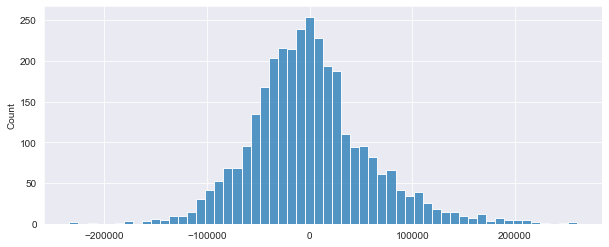

In [363]:
# a histogram of the residuals between y_train and y_pred
residuals = y_train - y_preds
fig = plt.figure(figsize=(10, 4))
sns.histplot(residuals)
plt.show()

# RMSE of predictions are very close to that of model 2
# We can see that the residuals are normally distributed, fulfilling one of our assumptions for linear modelling
# However not every variable has a linear relationship with price, nearest_station once again deffo does not have a linear relationship with price 
# Also homoscedasticity is not achieved as shown by the plot below with residuals vs nearest_station
# This model only meets 2/4 assumptions of linear regression - Normal distribution of residuals and lack of mulitcollinearity

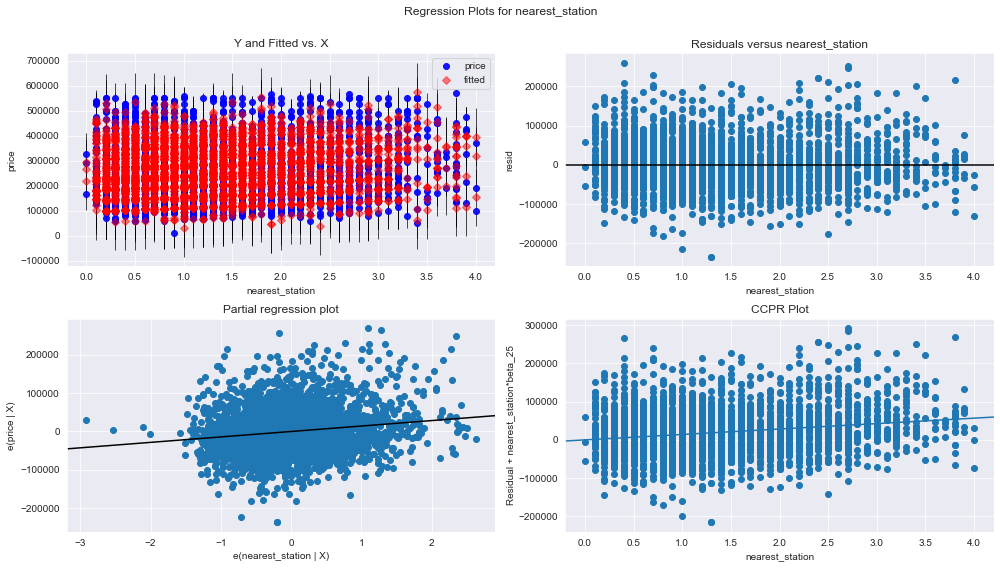

In [364]:
# Have a look to see if there is homoscedacitity
fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(model_stepwise, 'nearest_station', fig=fig)

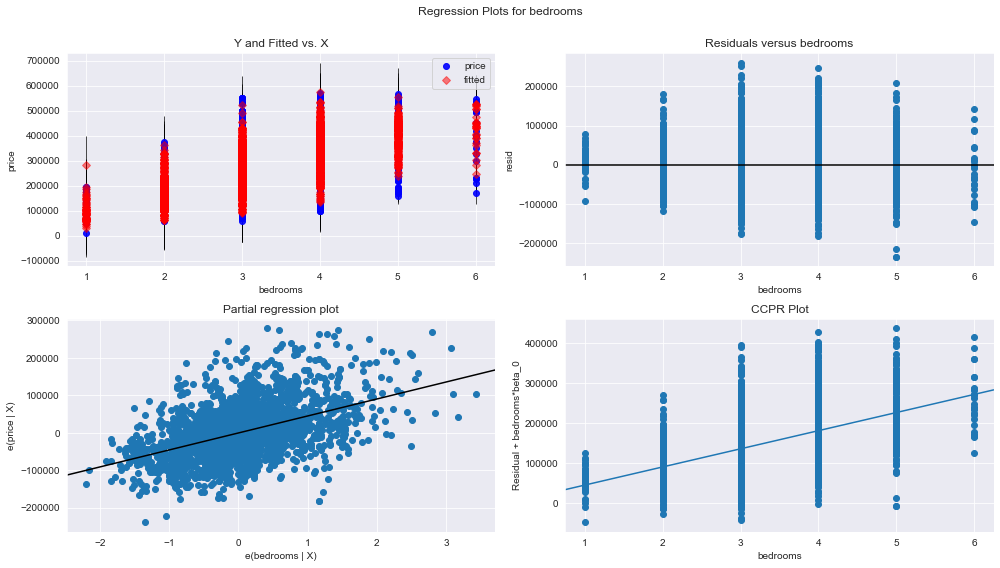

In [365]:
# Have a look to see if there is homoscedacitity
fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(model_stepwise, 'bedrooms', fig=fig)

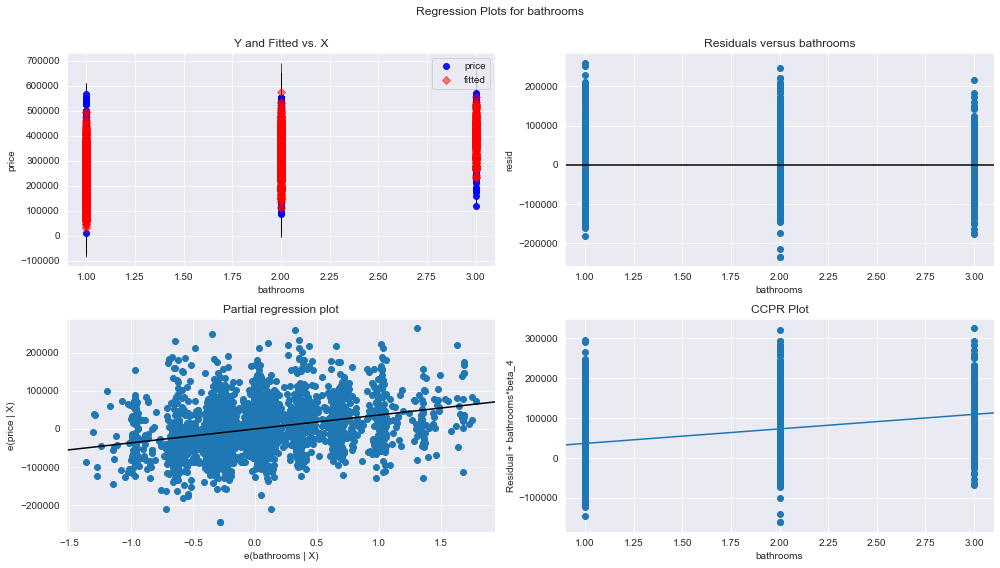

In [366]:
# Have a look to see if there is homoscedacitity
fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(model_stepwise, 'bathrooms', fig=fig)

# Linear Regression model (satisfies all four assumptions)



Try a model that has all the features identified by stepwise regression analysis, however drop the nearest_station feature as it does not have a linear relationship with price

- Observe it's RMSE
- Adjusted R^2 value in comparison to Model 2 and the previous stepwise regression analysis 
- See if matches all the assumptions of linear regression

In [367]:
# Use the cols identified by the function above
feature_cols.remove('nearest_station')
feature_cols

['bedrooms',
 'property_type_Terraced',
 'property_type_Semi-Detached',
 'outcode_LS29',
 'bathrooms',
 'outcode_LS16',
 'outcode_LS17',
 'outcode_LS15',
 'outcode_LS18',
 'outcode_LS8',
 'outcode_LS28',
 'outcode_LS6',
 'outcode_LS21',
 'outcode_LS19',
 'outcode_HD9',
 'outcode_LS20',
 'outcode_LS7',
 'outcode_BD23',
 'outcode_BD17',
 'outcode_LS26',
 'outcode_BD4',
 'outcode_HD8',
 'outcode_BD24',
 'outcode_BD20',
 'outcode_BD16',
 'outcode_LS25',
 'outcode_HX7',
 'outcode_HD7',
 'outcode_BD6',
 'outcode_WF1',
 'outcode_BD13',
 'outcode_LS22',
 'outcode_BD8',
 'outcode_WF14',
 'outcode_LS5',
 'outcode_BD18',
 'outcode_LS27',
 'outcode_WF2',
 'outcode_HD6',
 'outcode_LS13',
 'outcode_WF3',
 'outcode_BD5',
 'outcode_BD3',
 'outcode_BD7',
 'outcode_WF5',
 'outcode_LS24',
 'outcode_LS2',
 'outcode_HX6',
 'const']

In [368]:
# Create the linear regression model with features decided by stepwise regression analysis and nearest_station feature removed
model_stepwise_2 = linreg_fitter(y_train, X_train[feature_cols])
print(model_stepwise_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     184.5
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:42:26   Log-Likelihood:                -39752.
No. Observations:                3207   AIC:                         7.960e+04
Df Residuals:                    3158   BIC:                         7.990e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
bedrooms          

In [369]:
# Make predictions on train
y_preds = model_stepwise_2.predict(X_train[feature_cols])
rmse = statsmodels.tools.eval_measures.rmse(y_train, y_preds)
print(rmse)

58484.71756157613


In [370]:
# Make predictions on test
y_preds_test = model_stepwise_2.predict(X_test[feature_cols])
rmse = statsmodels.tools.eval_measures.rmse(y_test, y_preds_test)
print(rmse)

58990.052531564535


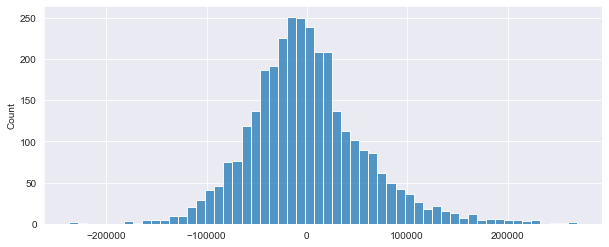

In [371]:
# a histogram of the residuals between y_train and y_pred
residuals = y_train - y_preds
fig = plt.figure(figsize=(10, 4))
sns.histplot(residuals)
plt.show()

# Once again can see a normality in the distribution of residuals
# Linear relationship between bedrooms and price and bathrooms and price

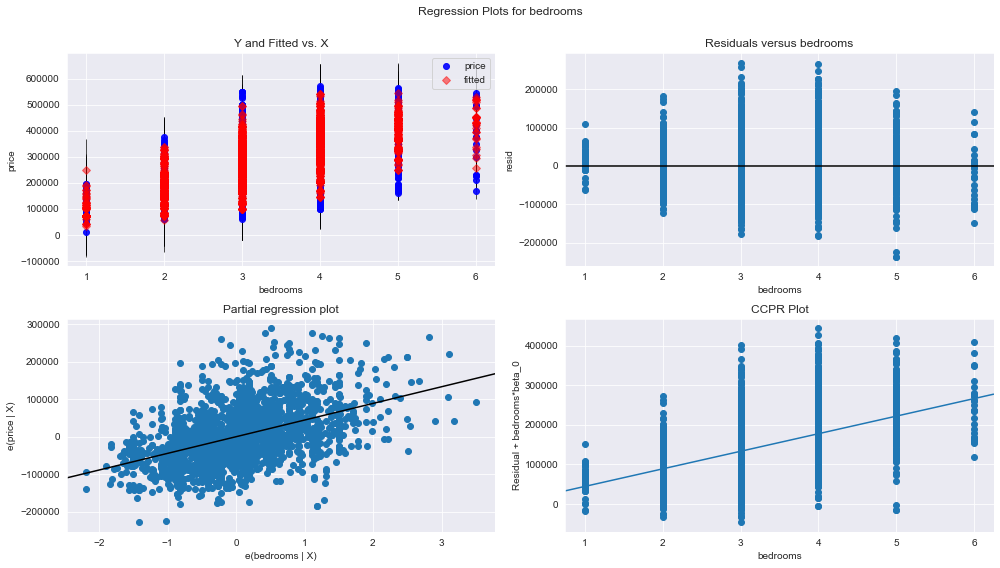

In [372]:
# Have a look to see if there is homoscedacitity
fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(model_stepwise_2, 'bedrooms', fig=fig)

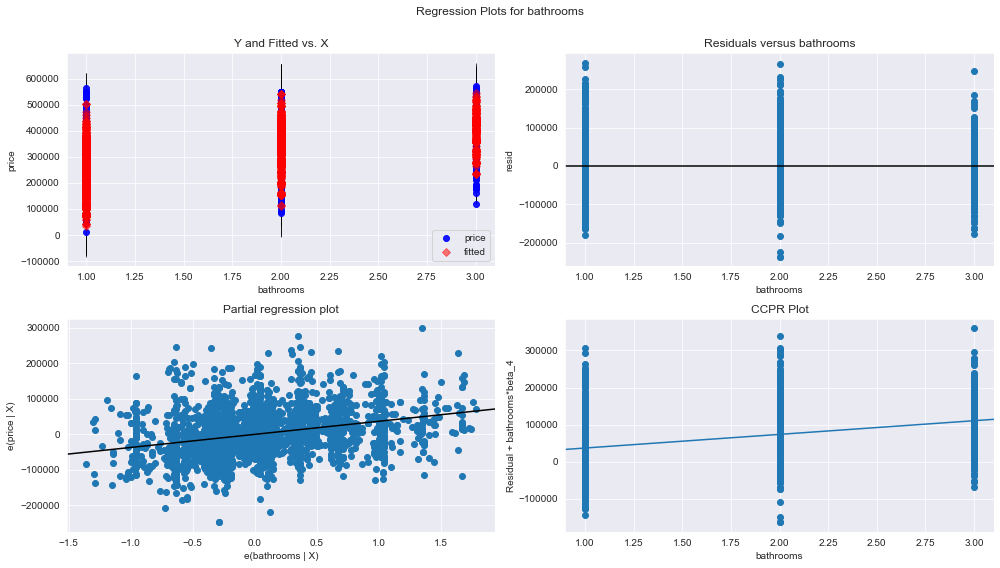

In [373]:
# Have a look to see if there is homoscedacitity
fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(model_stepwise_2, 'bathrooms', fig=fig)

In [374]:
# I believe this model satisfies 4/4 of the assumptions of linear regression
# There is a normal distribution of residuals
# The variables of bedroom and bathroom show a linear relationship with price
# There is homoscedasticity
# The Cond No is low enough to mean that there isn't strong multicollinearity
# Has an RMSE value on Test similar to that of Model 2 Base model

# VIF model applied on all features

In [375]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

## This a piece of code from stats.stackexchange.com

## It runs the model with all of the variables.
## If any of them have a higher VIF than 5, it drops the max.
## Then it keeps going until none of them have a higher VIF than 5.
## This leaves us with a nice set of features with no collineraity

def calculate_vif(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        # this bit uses list comprehension to gather all the VIF values of the different variables
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))  # getting the index of the highest VIF value
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]  # we delete the highest VIF value on condition that it's higher than the threshold
            dropped = True  # if we deleted anything, we set the 'dropped' value to True to stay in the while loop

    print('Remaining variables:')
    print(X.columns[variables])  # finally, we print the variables that are still in our set
    return X.iloc[:, variables]  # and return our X cut down to the remaining variables

In [376]:
feature_cols = list(X_train.columns)
feature_cols.remove('const')

In [377]:
feature_cols

['bedrooms',
 'bathrooms',
 'nearest_station',
 'property_type_Semi-Detached',
 'property_type_Terraced',
 'outcode_BD10',
 'outcode_BD11',
 'outcode_BD12',
 'outcode_BD13',
 'outcode_BD14',
 'outcode_BD15',
 'outcode_BD16',
 'outcode_BD17',
 'outcode_BD18',
 'outcode_BD19',
 'outcode_BD2',
 'outcode_BD20',
 'outcode_BD21',
 'outcode_BD22',
 'outcode_BD23',
 'outcode_BD24',
 'outcode_BD3',
 'outcode_BD4',
 'outcode_BD5',
 'outcode_BD6',
 'outcode_BD7',
 'outcode_BD8',
 'outcode_BD9',
 'outcode_HD1',
 'outcode_HD2',
 'outcode_HD3',
 'outcode_HD4',
 'outcode_HD5',
 'outcode_HD6',
 'outcode_HD7',
 'outcode_HD8',
 'outcode_HD9',
 'outcode_HX1',
 'outcode_HX2',
 'outcode_HX3',
 'outcode_HX4',
 'outcode_HX5',
 'outcode_HX6',
 'outcode_HX7',
 'outcode_LS10',
 'outcode_LS11',
 'outcode_LS12',
 'outcode_LS13',
 'outcode_LS14',
 'outcode_LS15',
 'outcode_LS16',
 'outcode_LS17',
 'outcode_LS18',
 'outcode_LS19',
 'outcode_LS2',
 'outcode_LS20',
 'outcode_LS21',
 'outcode_LS22',
 'outcode_LS23',
 

In [378]:
X_train_vif = calculate_vif(X_train[feature_cols])

dropping 'bedrooms' at index: 0
dropping 'nearest_station' at index: 1
dropping 'bathrooms' at index: 0
Remaining variables:
Index(['property_type_Semi-Detached', 'property_type_Terraced', 'outcode_BD10',
       'outcode_BD11', 'outcode_BD12', 'outcode_BD13', 'outcode_BD14',
       'outcode_BD15', 'outcode_BD16', 'outcode_BD17', 'outcode_BD18',
       'outcode_BD19', 'outcode_BD2', 'outcode_BD20', 'outcode_BD21',
       'outcode_BD22', 'outcode_BD23', 'outcode_BD24', 'outcode_BD3',
       'outcode_BD4', 'outcode_BD5', 'outcode_BD6', 'outcode_BD7',
       'outcode_BD8', 'outcode_BD9', 'outcode_HD1', 'outcode_HD2',
       'outcode_HD3', 'outcode_HD4', 'outcode_HD5', 'outcode_HD6',
       'outcode_HD7', 'outcode_HD8', 'outcode_HD9', 'outcode_HX1',
       'outcode_HX2', 'outcode_HX3', 'outcode_HX4', 'outcode_HX5',
       'outcode_HX6', 'outcode_HX7', 'outcode_LS10', 'outcode_LS11',
       'outcode_LS12', 'outcode_LS13', 'outcode_LS14', 'outcode_LS15',
       'outcode_LS16', 'outcode_LS17',

In [379]:
# Add constant
X_train_vif = sm.add_constant(X_train_vif)

In [380]:
# Create the fourth linear regression model
model_vif = linreg_fitter(y_train, X_train_vif)
print(model_vif.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     50.97
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:42:36   Log-Likelihood:                -40487.
No. Observations:                3207   AIC:                         8.115e+04
Df Residuals:                    3120   BIC:                         8.168e+04
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [381]:
# Make predictions on train
y_preds = model_vif.predict(X_train_vif)
rmse = statsmodels.tools.eval_measures.rmse(y_train, y_preds)
print(rmse)

73553.03369731028


In [382]:
feature_cols_vif = list(X_train_vif.columns)

In [383]:
# Make predictions on train
y_test_preds = model_vif.predict(X_test[feature_cols_vif])
rmse = statsmodels.tools.eval_measures.rmse(y_test, y_test_preds)
print(rmse)

74425.29795253614


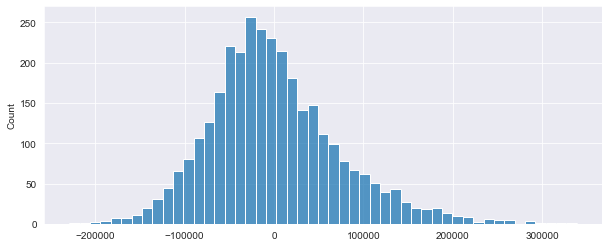

In [384]:
# a histogram of the residuals between y_train and y_pred
residuals = y_train - y_preds
fig = plt.figure(figsize=(10, 4))
sns.histplot(residuals)
plt.show()

# Does show a normal distribution of residuals
# There is not indepence, high multicollinearity
# No variables that remain are numerical in nature
# A high RMSE value

# DecisionTreeRegressor



In [385]:
from sklearn.tree import DecisionTreeRegressor
from time import time # Measure how long my code takes to run

In [386]:
def one_hot_encoding_keep_first(train_df, test_df, categorical_columns):

    # Drop following columns
    train_df = train_df.drop(columns=['url', 'address', 'tenure', 'cleaned_address','gcode','outcode_from_gcode'])
    test_df = test_df.drop(columns=['url', 'address', 'tenure', 'cleaned_address','gcode','outcode_from_gcode'])

    # Append constant
    # Add constant
    train_df = sm.add_constant(train_df)
    # Add constant
    test_df = sm.add_constant(test_df)

    # One Hot encode training dataset
    train_encoded = pd.get_dummies(train_df, columns=categorical_columns)

    # One Hot encode test dataset
    test_encoded = pd.get_dummies(test_df, columns=categorical_columns)

    # Check if all columns in the test dataset match the training dataset
    missing_columns = set(train_encoded.columns) - set(test_encoded.columns)

    for missing_col in missing_columns:
        test_encoded[missing_col] = 0  # Add missing columns to the test dataset with default value 0

    # Reorder test dataset columns to match the order in the training dataset
    test_encoded = test_encoded[train_encoded.columns]

    return train_encoded, test_encoded

In [387]:
allfeatures = list(df.columns)
allfeatures.remove('price')
# Create X, and y.
X = df[allfeatures]
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [388]:
## Feature engineering - keep the first as dummy as Decision Tree is a non-parametric ml algorithm
X_train, X_test = one_hot_encoding_keep_first(X_train, X_test, ['property_type','outcode'])

In [389]:
X_train.head()

,const,bedrooms,bathrooms,nearest_station,property_type_Detached,property_type_Semi-Detached,property_type_Terraced,outcode_BD1,outcode_BD10,outcode_BD11,...,outcode_WF16,outcode_WF17,outcode_WF2,outcode_WF3,outcode_WF4,outcode_WF5,outcode_WF6,outcode_WF7,outcode_WF8,outcode_WF9
2473,1.0,3,2,1.9,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1338,1.0,2,1,0.5,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1613,1.0,4,2,1.4,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1610,1.0,2,1,0.9,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2600,1.0,3,1,1.6,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [390]:
X_test.head()

,const,bedrooms,bathrooms,nearest_station,property_type_Detached,property_type_Semi-Detached,property_type_Terraced,outcode_BD1,outcode_BD10,outcode_BD11,...,outcode_WF16,outcode_WF17,outcode_WF2,outcode_WF3,outcode_WF4,outcode_WF5,outcode_WF6,outcode_WF7,outcode_WF8,outcode_WF9
2580,1.0,3,1,3.3,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3660,1.0,2,1,1.9,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
897,1.0,2,1,0.4,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2091,1.0,4,1,1.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1044,1.0,3,1,1.8,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [391]:
dtreg = DecisionTreeRegressor(max_depth=10, min_samples_split=10, random_state=5)

In [392]:
dtreg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, min_samples_split=10, random_state=5)

In [393]:
dtreg.feature_importances_

array([0.00000000e+00, 5.06202737e-01, 3.91460130e-02, 3.59386906e-02,
       6.22843327e-02, 7.10693268e-02, 1.24852362e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.05742883e-03, 4.34399494e-03,
       0.00000000e+00, 1.62585672e-03, 4.89382468e-05, 9.45572364e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.99706850e-03,
       0.00000000e+00, 1.35221130e-03, 5.05054922e-04, 0.00000000e+00,
       0.00000000e+00, 2.16820095e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.96227097e-03,
       1.12564359e-03, 0.00000000e+00, 3.02873090e-03, 0.00000000e+00,
       0.00000000e+00, 2.29824208e-04, 6.48379912e-04, 1.76970963e-03,
       1.58144827e-03, 0.00000000e+00, 1.16581464e-03, 0.00000000e+00,
       1.27826944e-03, 0.00000000e+00, 1.52018660e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.27963688e-03,
       7.18828724e-03, 1.71808135e-02, 1.02971661e-02, 7.13630319e-03,
      

In [394]:
y_pred = dtreg.predict(X_train)

In [395]:
rmse = statsmodels.tools.eval_measures.rmse(y_train, y_pred)
print(rmse)

56847.972089515046


In [396]:
y_pred_test = dtreg.predict(X_test)

In [397]:
rmse = statsmodels.tools.eval_measures.rmse(y_test, y_pred_test)
print(rmse)

70962.19459601148


Can see a lot of overfitting for this DecisionTreeRegressor, let's use GridSearchCV to find the best hyperparameters to make a robust DecisionTreeRegressor i.e. handle overfitting

# Robust Decision Tree Regressor

In [398]:
from sklearn.model_selection import GridSearchCV # Helps us select the best parameters for model
grid = GridSearchCV(estimator = DecisionTreeRegressor(),
                    param_grid = {'max_depth': [3, 5, 7, 10, 12, 15, 20],
                                  'min_samples_split': [50, 100, 150, 200, 500, 1000], # Minimum number of samples to make a split
                                  'min_samples_leaf': [20, 30, 40, 50, 60, 70], # Minimum number of samples to have in a leaf
                                  'max_features':[2,86]}, # How many features it will use to make a decision
                    cv = 10, # Number of folds it uses
                    refit = True, # Should I learn from previous iterations
                    verbose = 1, # Either 0,1 or 2 how much should I tell the programmer
                    scoring = 'neg_mean_squared_error') # Which metric am I looking to prioritise

In [399]:
# Timing the grid search using the timing library
now = time()
grid.fit(X_train, y_train)
print(f' Time in seconds: {time() - now}')

Fitting 10 folds for each of 504 candidates, totalling 5040 fits
 Time in seconds: 44.14463210105896


In [400]:
# Check the best parameters resulting from our search!
grid.best_params_

{'max_depth': 7,
 'max_features': 86,
 'min_samples_leaf': 20,
 'min_samples_split': 50}

In [401]:
grid.best_score_

-5136678636.120249

In [402]:
# This is the best model I came up with
grid.best_estimator_

DecisionTreeRegressor(max_depth=7, max_features=86, min_samples_leaf=20,
                      min_samples_split=50)

In [403]:
# DecisionTreeRegressor with hyperparameters identified by GridSearchCV
robustdectreereg = DecisionTreeRegressor(max_depth=7, max_features=86, min_samples_split=20, min_samples_leaf=50)

In [404]:
robustdectreereg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=7, max_features=86, min_samples_leaf=50,
                      min_samples_split=20)

In [405]:
y_pred = robustdectreereg.predict(X_train)

In [406]:
# RMSE of robust dtregressor on train
rmse = statsmodels.tools.eval_measures.rmse(y_train, y_pred)
print(rmse)

71729.04133314703


In [407]:
y_pred_test = robustdectreereg.predict(X_test)

In [408]:
# RMSE of robust dtregressor on test
rmse = statsmodels.tools.eval_measures.rmse(y_test, y_pred_test)
print(rmse)

70142.49723937627


In [409]:
# Can see that this is robust, no overfitting between train and test - diff of less than £200
# This is still not better than the linear regression model that satisfies the four assumptions of linear regression with nearest station not used as a feature value
# That model presents the best RMSE value so far

# KNeighborsRegressor

- See the performance of the KNeighbourRegressor
- Will find the best hyperparameters for k and distance metric
- Will look for the most robust model (least likely to have overfitting)
- See what value of k from the graph means the least overfitting 

In [410]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
from math import sqrt

In [411]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train) ## Fit on train!!!

X_train_scaled = scaler.transform(X_train) ##  Transform the training set according to the scaler
X_test_scaled = scaler.transform(X_test) ## Transform on the testing set according to the scaler
X_train = pd.DataFrame(X_train_scaled) # Make into dataframe 
X_test = pd.DataFrame(X_test_scaled) # Make into dataframe

In [412]:
# See if changes have applied
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,0.0,0.4,0.5,0.475,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.2,0.0,0.125,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.6,0.5,0.350,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.2,0.0,0.225,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.4,0.0,0.400,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [413]:
# See if changes have applied
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,0.0,0.4,0.0,0.825,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.2,0.0,0.475,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.2,0.0,0.100,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.6,0.0,0.250,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.4,0.0,0.450,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [414]:
# Use a GridSearch to find the best K value and the best distance metric
params = {'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],
          'metric' : ['minkowski', 'euclidean', 'manhattan', 'hamming'],
          }

In [415]:
# Use GridSearch to find the best value for K and the best distance metric
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=10)
model.fit(X_train, y_train)
model.best_params_

{'metric': 'hamming', 'n_neighbors': 15}

In [416]:
# Get all the RMSE values when using k and hamming distance as the distance metric
rmse_val = [] #to store rmse values for different k
for K in range(30):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K, metric='hamming')

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_train) #make prediction on train set
    error = sqrt(mean_squared_error(y_train, pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 28265.98162106695
RMSE value for k=  2 is: 42397.55689020151
RMSE value for k=  3 is: 48294.99750340573
RMSE value for k=  4 is: 51343.736043492434
RMSE value for k=  5 is: 53434.1679653758
RMSE value for k=  6 is: 54897.57124771693
RMSE value for k=  7 is: 56349.57728731329
RMSE value for k=  8 is: 57314.328193489484
RMSE value for k=  9 is: 58107.16011307788
RMSE value for k=  10 is: 58635.089443769044
RMSE value for k=  11 is: 59243.3665685201
RMSE value for k=  12 is: 59845.126142107154
RMSE value for k=  13 is: 60210.26217313289
RMSE value for k=  14 is: 60632.0348492472
RMSE value for k=  15 is: 61112.79278025732
RMSE value for k=  16 is: 61487.28156758886
RMSE value for k=  17 is: 61906.8586426574
RMSE value for k=  18 is: 62317.674077604344
RMSE value for k=  19 is: 62643.754606993774
RMSE value for k=  20 is: 62832.630290779955
RMSE value for k=  21 is: 63106.34408601905
RMSE value for k=  22 is: 63287.41403528023
RMSE value for k=  23 is: 63507.161168

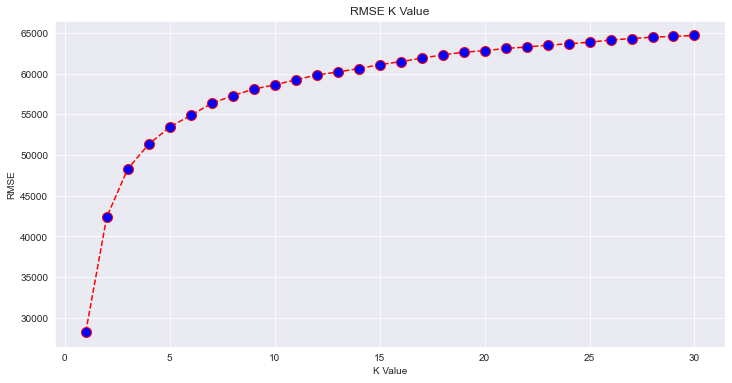

In [417]:
## Pick a value for K
## Never pick K equals 1
plt.figure(figsize=(12, 6))
plt.plot(range(1, 31)
         , rmse_val
         , color='red'
         , linestyle='dashed'
         , marker='o'
         , markerfacecolor='blue'
         , markersize=10)
plt.title('RMSE K Value')
plt.xlabel('K Value')
plt.ylabel('RMSE')
plt.show()

In [418]:
# Make a prediction on test using with best value for K as identified by grid search, and the best distance metric
knnreg = neighbors.KNeighborsRegressor(n_neighbors = 15, metric='hamming')
knnreg.fit(X_train, y_train)
pred_test=knnreg.predict(X_test) #make prediction on test set

In [419]:
rmseerror = sqrt(mean_squared_error(y_test, pred_test)) #calculate rmse on test
rmseerror

65077.20091787593

## Notes on KNeighborRegressor
- When K=15 and using hamming distance for the distance metric for the KNN regressor as defined to be the best hyperparameters for KNREegressor by gridsearch
- The RMSE on train when K is 9 is: £61112.79278025732
- Whilst the RMSE on test is: £65077.20091787593
- This is a lot of overfitting in comparison to the LR and DTRegressor
- This is the most robust as it has the best average rmse score over the 10 folds of unseen data for training set

# Selecting best model 

Model                  | Features used                                                          | RMSE on Train | RMSE on Test |
-----------------------|------------------------------------------------------------------------|---------------|--------------|
Linear Regression      | Features returned from stepwise regression and nearest_station removed | £58484.72     | £58990.05    |
DecisionTreeRegressor  | All                                                                    | £71443.63     | £69985.74    |
KNeighborsRegressor    | All                                                                    | £61112.79     | £65077.29    |

This shows Linear Regression to be the best however for the case of our function, having a typical error of nearly £60,000 is not great

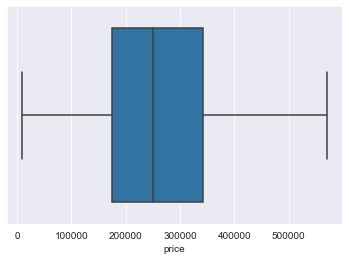

In [420]:
# Do a boxplot for price
sns.boxplot(data=df, x='price')
plt.show()

In [421]:
# Median value for price - £250,000
df.describe()

,bedrooms,bathrooms,nearest_station,price
count,4009.000000,4009.000000,4009.000000,4009.000000
mean,3.161137,1.431778,1.357471,264763.756797
std,0.876891,0.628973,0.836925,113864.992021
min,1.000000,1.000000,0.000000,10000.000000
25%,3.000000,1.000000,0.700000,175000.000000
50%,3.000000,1.000000,1.200000,250000.000000
75%,4.000000,2.000000,1.900000,343000.000000
max,6.000000,3.000000,4.000000,570000.000000


Perhaps I could split the data to build two Linear Regression models, one for lower price properties and one for higher properties

- Lower price properties would lie in the range of £10000-£250,000
- High price properties would lie in the range of £250,001-£570,000

In [422]:
# Split the data
df_low_price = df[(df['price'] >= 10000) & (df['price'] <= 250000)]

In [423]:
df_low_price.shape[0]

2088

In [424]:
# Split the data
df_higher_price = df[(df['price'] > 250000) & (df['price'] <= 570000)]

In [425]:
df_higher_price.shape[0]

1921

#  Linear Regression - for lower price properties (£10,000-£250,000)

In [578]:
# Linear Regression - for lower price properties
# Will not make use of the nearest_station feature as to make this sure this feature satisfies all four assumptions of Linear Regression
# Create a column of all features
allfeatures = list(df_low_price.columns)
allfeatures.remove('price')
# Create X, and y.
X = df_low_price[allfeatures]
y = df_low_price['price']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [579]:
## Feature engineering
X_train, X_test = one_hot_encoding(X_train, X_test, ['property_type','outcode'])

In [580]:
# Check equal number of columns
X_train.head()

,const,bedrooms,bathrooms,nearest_station,property_type_Semi-Detached,property_type_Terraced,outcode_BD10,outcode_BD11,outcode_BD12,outcode_BD13,...,outcode_WF16,outcode_WF17,outcode_WF2,outcode_WF3,outcode_WF4,outcode_WF5,outcode_WF6,outcode_WF7,outcode_WF8,outcode_WF9
106,1.0,3,3,1.7,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1453,1.0,3,1,0.8,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2787,1.0,2,1,0.5,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
294,1.0,2,1,1.3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
486,1.0,2,1,0.9,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [581]:
# Check equal number of columns
X_test.head()

,const,bedrooms,bathrooms,nearest_station,property_type_Semi-Detached,property_type_Terraced,outcode_BD10,outcode_BD11,outcode_BD12,outcode_BD13,...,outcode_WF16,outcode_WF17,outcode_WF2,outcode_WF3,outcode_WF4,outcode_WF5,outcode_WF6,outcode_WF7,outcode_WF8,outcode_WF9
1183,1.0,2,1,0.9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2904,1.0,3,1,0.3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
678,1.0,3,1,1.2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1289,1.0,2,1,0.6,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3569,1.0,3,1,0.5,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [582]:
# Remove the nearest_station column from the list of feature columns to use - does not have a linear relationship with price
feature_cols = list(X_train.columns)
feature_cols.remove('nearest_station')
feature_cols.remove('const')

In [583]:
# Apply stepwise regression analysis
# Made sure to remove the const column
result = stepwise_selection(X_train[feature_cols], y_train)
print('resulting features:')
print(result)

Add  property_type_Terraced         with p-value 5.86648e-99
Add  bedrooms                       with p-value 1.70016e-43
Add  bathrooms                      with p-value 1.18442e-11
Add  outcode_LS15                   with p-value 1.65155e-10
Add  outcode_BD4                    with p-value 2.93742e-09
Add  outcode_HX1                    with p-value 1.6763e-06
Add  outcode_BD3                    with p-value 3.75637e-06
Add  outcode_BD8                    with p-value 1.00127e-05
Add  property_type_Semi-Detached    with p-value 1.06453e-05
Add  outcode_LS26                   with p-value 4.42291e-06
Add  outcode_LS19                   with p-value 6.4903e-06
Add  outcode_LS18                   with p-value 8.53178e-06
Add  outcode_LS4                    with p-value 1.11541e-05
Add  outcode_LS28                   with p-value 1.02189e-05
Add  outcode_LS29                   with p-value 1.0802e-05
Add  outcode_LS25                   with p-value 1.5753e-05
Add  outcode_LS20           

In [584]:
# Make the feature columns those that are statistically significant as shown above
feature_cols = result
feature_cols.append('const')

In [585]:
# Create the linear regression model with features decided by stepwise regression analysis and nearest_station feature removed
lrmodel_low = linreg_fitter(y_train, X_train[feature_cols])
print(lrmodel_low.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     44.71
Date:                Wed, 29 Mar 2023   Prob (F-statistic):          3.87e-255
Time:                        15:25:37   Log-Likelihood:                -19682.
No. Observations:                1670   AIC:                         3.946e+04
Df Residuals:                    1622   BIC:                         3.972e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
property_type_Terr

In [586]:
# Make predictions on train
X_train['y_preds'] = lrmodel_low.predict(X_train[feature_cols])
rmse = statsmodels.tools.eval_measures.rmse(y_train, X_train['y_preds'])
print(rmse)

31792.24852111878


In [587]:
# Have a look at predictions
X_train.head()

,const,bedrooms,bathrooms,nearest_station,property_type_Semi-Detached,property_type_Terraced,outcode_BD10,outcode_BD11,outcode_BD12,outcode_BD13,...,outcode_WF17,outcode_WF2,outcode_WF3,outcode_WF4,outcode_WF5,outcode_WF6,outcode_WF7,outcode_WF8,outcode_WF9,y_preds
106,1.0,3,3,1.7,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,238414.772515
1453,1.0,3,1,0.8,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,123591.951438
2787,1.0,2,1,0.5,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,131378.442142
294,1.0,2,1,1.3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,166420.702564
486,1.0,2,1,0.9,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,166420.702564


In [588]:
# Make predictions on test
X_test['y_preds'] = lrmodel_low.predict(X_test[feature_cols])
rmse = statsmodels.tools.eval_measures.rmse(y_test, X_test['y_preds'])
print(rmse)

33455.23396052771


In [589]:
# Have a look at predictions
X_test.head()

,const,bedrooms,bathrooms,nearest_station,property_type_Semi-Detached,property_type_Terraced,outcode_BD10,outcode_BD11,outcode_BD12,outcode_BD13,...,outcode_WF17,outcode_WF2,outcode_WF3,outcode_WF4,outcode_WF5,outcode_WF6,outcode_WF7,outcode_WF8,outcode_WF9,y_preds
1183,1.0,2,1,0.9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,218457.873229
2904,1.0,3,1,0.3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,187504.549653
678,1.0,3,1,1.2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,220657.777498
1289,1.0,2,1,0.6,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,205847.816170
3569,1.0,3,1,0.5,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,152462.289231


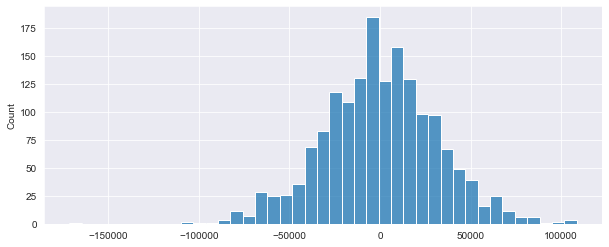

In [590]:
## Check does it still match the assumptions of linear regression
# a histogram of the residuals between y_train and y_pred
residuals = y_train - X_train['y_preds']
fig = plt.figure(figsize=(10, 4))
sns.histplot(residuals)
plt.show()
# Once again can see a normality in the distribution of residuals
# Linear relationship between bedrooms and price and bathrooms and price

In [591]:
# Shapiro test to see if it is a normal distribution
shapiro_test = stats.shapiro(residuals)
shapiro_test.statistic

0.9960324168205261

In [592]:
shapiro_test.pvalue

0.0002338741032872349

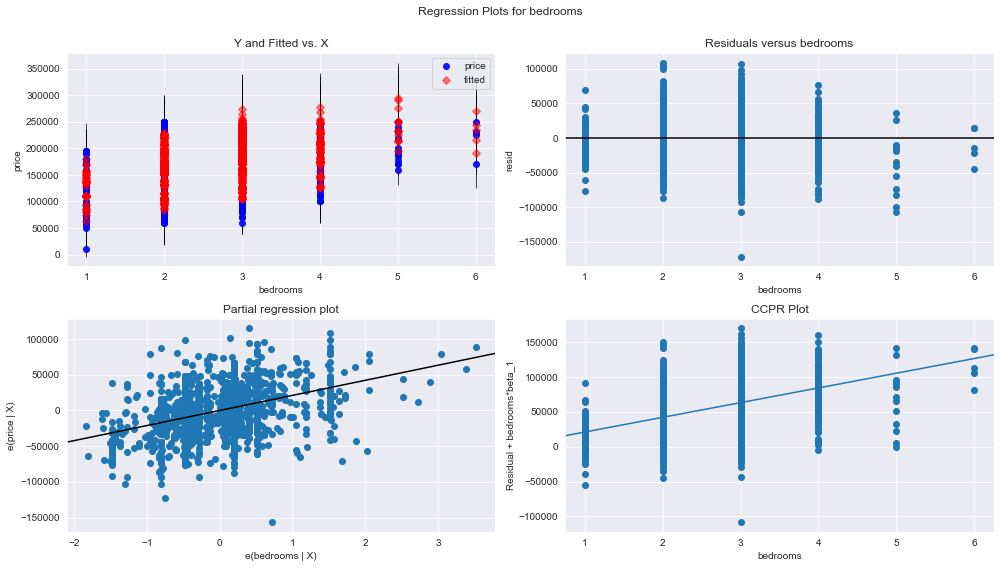

In [593]:
# Have a look to see if there is homoscedacitity - top right plot
fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(lrmodel_low, 'bedrooms', fig=fig)

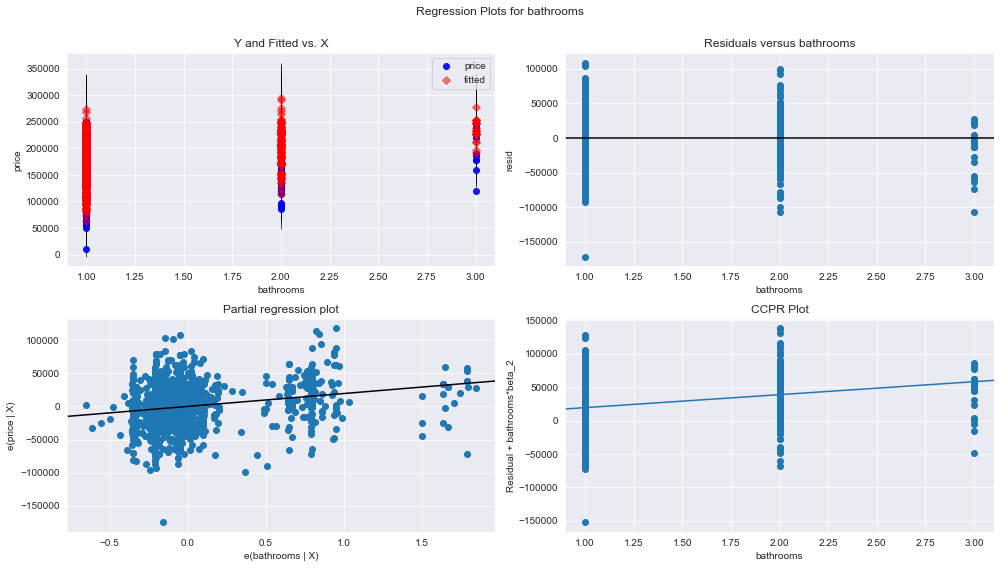

In [594]:
# Have a look to see if there is homoscedacitity
fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(lrmodel_low, 'bathrooms', fig=fig)

- This model satisfies all 4 assumptions of linear regression
-  Linear relationship between bedrooms and price and bathrooms and price
- Normal distribution of residuals
- No multicollinearity
- Homoscedasticity,

# Linear Regression - for higher price properties (£250,001-£570,000)

In [595]:
# Linear Regression - for higher price properties
# Will not make use of the nearest_station feature as to make this sure this feature satisfies all four assumptions of Linear Regression
# Create a column of all features
allfeatures = list(df_higher_price.columns)
allfeatures.remove('nearest_station') # Remove the nearest_station column from the list of feature columns to use - does not have a linear relationship with price
allfeatures.remove('price')
# Create X, and y.
X = df_higher_price[allfeatures]
y = df_higher_price['price']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [596]:
## Feature engineering
X_train, X_test = one_hot_encoding(X_train, X_test, ['property_type','outcode'])

In [597]:
feature_cols = list(X_train.columns)
feature_cols.remove('const') 

In [598]:
# Apply stepwise regression analysis
# Made sure to remove the const column
result = stepwise_selection(X_train[feature_cols], y_train)
print('resulting features:')
print(result)

Add  bedrooms                       with p-value 5.72802e-71
Add  property_type_Semi-Detached    with p-value 9.41861e-19
Add  property_type_Terraced         with p-value 2.11299e-14
Add  outcode_LS29                   with p-value 9.21983e-12
Add  outcode_LS17                   with p-value 1.00228e-10
Add  bathrooms                      with p-value 2.65349e-08
Add  outcode_WF10                   with p-value 5.57608e-07
Add  outcode_LS8                    with p-value 1.89722e-06
Add  outcode_LS16                   with p-value 1.15248e-06
Add  outcode_LS18                   with p-value 1.97978e-05
Add  outcode_HD9                    with p-value 0.000123781
Add  outcode_LS15                   with p-value 0.000161324
Add  outcode_BD17                   with p-value 0.000326998
Add  outcode_LS10                   with p-value 0.000453228
Add  outcode_BD4                    with p-value 0.000630039
Add  outcode_BD6                    with p-value 0.00112174
Add  outcode_LS6         

In [599]:
# Make the feature columns those that are statistically significant as shown above
feature_cols = result
feature_cols.append('const')

In [600]:
# Create the linear regression model with features decided by stepwise regression analysis and nearest_station feature removed
lrmodel_high = linreg_fitter(y_train, X_train[feature_cols])
print(lrmodel_high.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     42.77
Date:                Wed, 29 Mar 2023   Prob (F-statistic):          1.17e-155
Time:                        15:25:49   Log-Likelihood:                -19125.
No. Observations:                1536   AIC:                         3.830e+04
Df Residuals:                    1510   BIC:                         3.844e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
bedrooms          

In [601]:
# Make predictions on train
X_train['y_preds'] = lrmodel_high.predict(X_train[feature_cols])
rmse = statsmodels.tools.eval_measures.rmse(y_train, X_train['y_preds'])
print(rmse)

61836.76336272289


In [602]:
# Have a look at predictions
X_train.head()

,const,bedrooms,bathrooms,property_type_Semi-Detached,property_type_Terraced,outcode_BD11,outcode_BD12,outcode_BD13,outcode_BD14,outcode_BD15,...,outcode_WF17,outcode_WF2,outcode_WF3,outcode_WF4,outcode_WF5,outcode_WF6,outcode_WF7,outcode_WF8,outcode_WF9,y_preds
825,1.0,3,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,356011.110680
338,1.0,3,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,308731.543156
2315,1.0,3,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,356860.362630
1974,1.0,3,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,377004.085918
3868,1.0,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,369942.387213


In [603]:
# Make predictions on test
X_test['y_preds'] = lrmodel_high.predict(X_test[feature_cols])
rmse = statsmodels.tools.eval_measures.rmse(y_test, X_test['y_preds'])
print(rmse)

56889.83354015525


In [604]:
# Have a look at predictions
X_test.head()

,const,bedrooms,bathrooms,property_type_Semi-Detached,property_type_Terraced,outcode_BD11,outcode_BD12,outcode_BD13,outcode_BD14,outcode_BD15,...,outcode_WF17,outcode_WF2,outcode_WF3,outcode_WF4,outcode_WF5,outcode_WF6,outcode_WF7,outcode_WF8,outcode_WF9,y_preds
2028,1.0,4,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,414473.129365
3354,1.0,3,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,301491.486724
1098,1.0,3,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,281347.763435
962,1.0,5,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,431798.449523
812,1.0,3,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,348771.054247


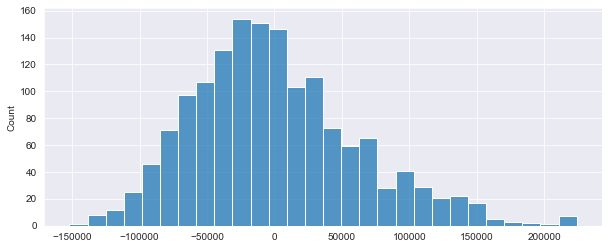

In [605]:
## Check does it still match the assumptions of linear regression
# a histogram of the residuals between y_train and y_pred
residuals = y_train - X_train['y_preds']
fig = plt.figure(figsize=(10, 4))
sns.histplot(residuals)
plt.show()
# This does the match four assumptions of linear reggression
# Linear relationship between bedrooms and price and bathrooms and price
# Normal distribution of residuals - as evidenced by the shapiro
# No multicollinearity
# Homoscedasticity,

In [606]:
# Shapiro test to see if plot above has normality
shapiro_test = stats.shapiro(residuals)

In [607]:
shapiro_test.statistic

0.9763597846031189

In [608]:
shapiro_test.pvalue

3.324061158095702e-15

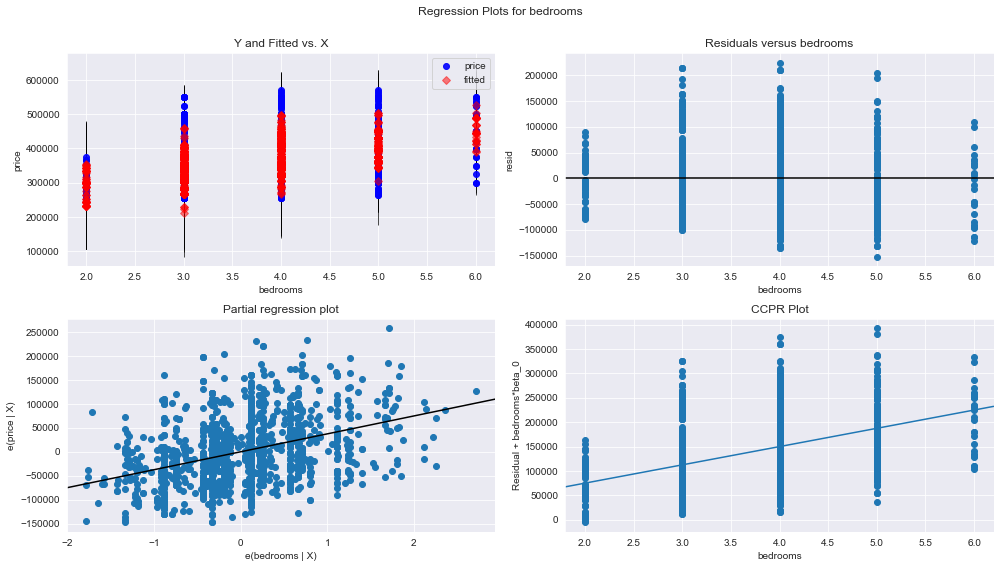

In [609]:
# Have a look to see if there is homoscedacitity - there is
fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(lrmodel_high, 'bedrooms', fig=fig)

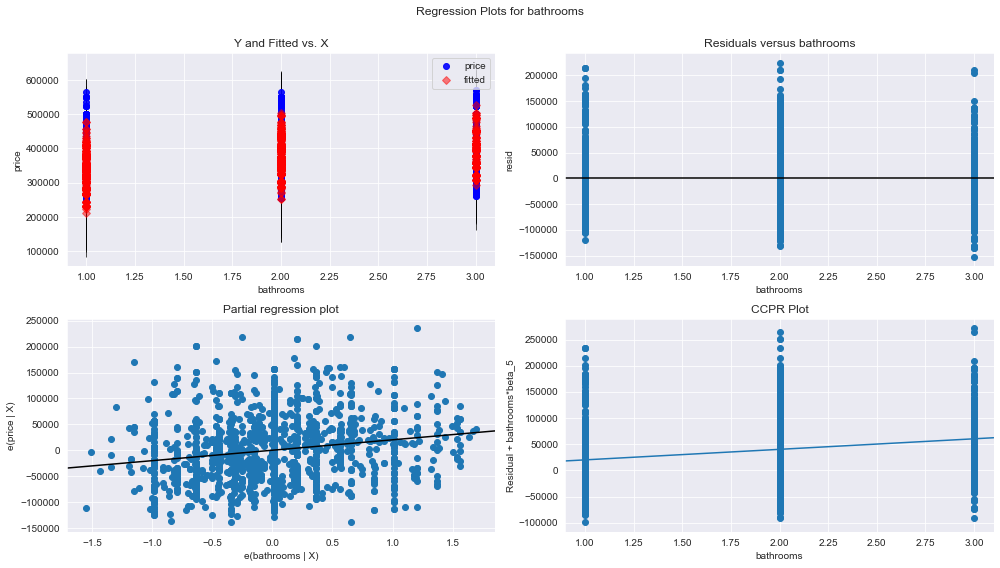

In [610]:
# Have a look to see if there is homoscedacitity - there is
fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(lrmodel_high, 'bathrooms', fig=fig)

Model                  | Features used                                                       | RMSE on Train | RMSE on Test | RMSE % of the max price |
-----------------------|---------------------------------------------------------------------|---------------|--------------| ------------------------|
Linear Regression (£10000-£250000)      | Features returned from stepwise regression and nearest_station removed | £31792.25     | £33455.23    | ~ 13% |
Linear Regression (£250001-£570000)  | Features returned from stepwise regression and nearest_station removed                                                                    | £61836.76     | £56889.83    | ~ 10% |

# Save our two models

In [611]:
import pickle

pickle.dump(lrmodel_low, open('../Function/lrmodel_low.pkl', 'wb'))
pickle.dump(lrmodel_high, open('../Function/lrmodel_high.pkl', 'wb'))